In [8]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [9]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [10]:
# same as sklearn 
df = pd.read_csv("data/allHorizonData_cut.csv")

seq_features = [
    'r1', 'c1', 'rt1',
    'r2', 'c2', 'rt2',
    'r3', 'c3', 'rt3',
    'r4', 'c4', 'rt4'
]
static_features = ['gameLength', 'uc']

target = 'c5'

# only keep the first trial per subject
print(f"Original df shape: {df.shape}")
df = df.groupby('subjectID').head(1).reset_index(drop=True)
print(f"New df shape: {df.shape}")

X_seq = df[seq_features]
X_static = df[static_features]
y = df[target]
y = y-1 # binary CE only takes in 0, 1

print(type(X_seq))
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(X_seq, X_static, y, test_size=0.2, random_state=42)
print(type(X_seq_train))

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())


# split based on original data frame
h1_mask = X_static_test['gameLength'] == 5
h6_mask = X_static_test['gameLength'] == 10
X_static_test_raw = X_static_test.copy()

scaler = StandardScaler()
X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)



# X_seq_train = X_seq_train.to_numpy()
# X_seq_test = X_seq_test.to_numpy()
# X_static_train = X_static_train.to_numpy()
# X_static_test = X_static_test.to_numpy()

print("After scaling:")
print(f'X_seq_train {X_seq_train[0]}')
print(f'X_static_train {X_static_train[0]}')
print(f'y_train {y_train.iloc[0]}')

Original df shape: (19200, 41)
New df shape: (60, 41)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
--- Feature Data (X) ---
   r1  c1       rt1  r2  c2       rt2  r3  c3       rt3  r4  c4       rt4
0  66   2  1.849054  80   2  1.771619  29   1  0.562676  75   2  0.578808
1  42   2  0.701176  69   1  0.518629  42   2  0.519894  69   1  0.480364
2  58   2  8.718367  47   2  1.001007  70   2  1.664248  80   1  1.540207
3  74   2  0.864517  67   2  0.596223  61   2  0.930913  60   1  0.563235
4  46   2  2.610086  43   2  0.647100  47   2  0.419367  59   1  0.488821
   gameLength  uc
0           5   3
1          10   2
2          10   3
3           5   3
4          10   3

--- Target Data (y) ---
0    1
1    1
2    0
3    1
4    0
Name: c5, dtype: int64
After scaling:
X_seq_train [ 0.3411502   0.77459667 -0.23323531 -1.44580466 -1.18321596 -0.21348721
  0.52393905  1.18321596 -0.58265977  0.04779379  0.9591663  -0.38636314]
X_static_train [0.6094494  1.2084987

In [11]:
feature_order_test = np.array(seq_features).reshape(-1, 4, 3)
print(feature_order_test)

[[['r1' 'c1' 'rt1']
  ['r2' 'c2' 'rt2']
  ['r3' 'c3' 'rt3']
  ['r4' 'c4' 'rt4']]]


In [12]:
print(X_seq_train.shape)
print(type(X_seq_train))
print(type(y_train))

(48, 12)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [13]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, 4, 3)
print(X_seq_train.shape)
print(type(X_seq_train))
print(X_seq_train[0])
X_seq_test = X_seq_test.reshape(-1, 4, 3)
print(X_seq_test.shape)
print(type(X_seq_test))

(48, 4, 3)
<class 'numpy.ndarray'>
[[ 0.3411502   0.77459667 -0.23323531]
 [-1.44580466 -1.18321596 -0.21348721]
 [ 0.52393905  1.18321596 -0.58265977]
 [ 0.04779379  0.9591663  -0.38636314]]
(12, 4, 3)
<class 'numpy.ndarray'>


convert to tensor for pytorch

In [14]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [15]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [16]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask, dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask, dtype=torch.bool)

X_seq_test_h1 = torch.tensor(X_seq_test[h1_mask_bool], dtype=torch.float32)
X_seq_test_h6 = torch.tensor(X_seq_test[h6_mask_bool], dtype=torch.float32)

X_static_test_h1 = torch.tensor(X_static_test[h1_mask_bool], dtype=torch.float32)
X_static_test_h6 = torch.tensor(X_static_test[h6_mask_bool], dtype=torch.float32)

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]


In [17]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [18]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [19]:
class RNN(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(seq_input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        rnn_out, h_n = self.rnn(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate RNN output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output


In [20]:
class LSTM(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=128, output_size=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 64), # combine static inputs
            nn.GELU(),
            nn.Linear(64, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        rnn_out, (h_n, c_n) = self.lstm(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate RNN output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

In [21]:
class GRU(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(GRU, self).__init__()
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        gru_out, h_n = self.gru(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate GRU output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

In [22]:
class TinyGRU(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=2, output_size=2):
        super(TinyGRU, self).__init__()
        self.gru = nn.RNN(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 2), # combine static inputs
            nn.ReLU(),
            nn.Linear(2, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        gru_out, h_n = self.gru(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate GRU output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

# train / eval

In [23]:
def train(model, train_loader, criterion, optimizer, device, epoch): 
    model.train()
    train_loss = 0.0
    for seq_inputs, static_inputs, labels in train_loader:
        seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(seq_inputs, static_inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss


def test(model, test_loader, device):
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for seq_inputs, static_inputs, labels in test_loader:
            seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
            preds = model(seq_inputs, static_inputs)
            preds = preds.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

# running experiment

In [24]:
model = TinyGRU().to(device)
print(model)

TinyGRU(
  (gru): RNN(3, 2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
)


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
epochs = 20
loss_prog = []
acc_prog = []
acc_h1_prog = []
acc_h6_prog = []

for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer, device, epoch)
    acc = test(model, test_loader, device)
    acc_h1 = test(model, test_loader_h1, device)
    acc_h6 = test(model, test_loader_h6, device)
    print(f"Epoch {epoch+1}: Loss: {loss:.4f} | overall: {acc:.4f} | H1 {acc_h1:.4f} | H6 {acc_h6:.4f}")

    loss_prog.append(loss)
    acc_prog.append(acc)
    acc_h1_prog.append(acc_h1)
    acc_h6_prog.append(acc_h6)

Epoch 1: Loss: 0.8560 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 2: Loss: 0.8693 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 3: Loss: 0.8459 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 4: Loss: 0.8251 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 5: Loss: 0.8548 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 6: Loss: 0.8499 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 7: Loss: 0.8137 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 8: Loss: 0.8303 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 9: Loss: 0.8108 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 10: Loss: 0.8423 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 11: Loss: 0.8175 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 12: Loss: 0.8263 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 13: Loss: 0.8124 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 14: Loss: 0.8110 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 15: Loss: 0.8011 | overall: 0.3333 | H1 0.2500 | H6 0.3750
Epoch 16: Loss: 0.8334 | overall: 

In [27]:
import matplotlib.pyplot as plt

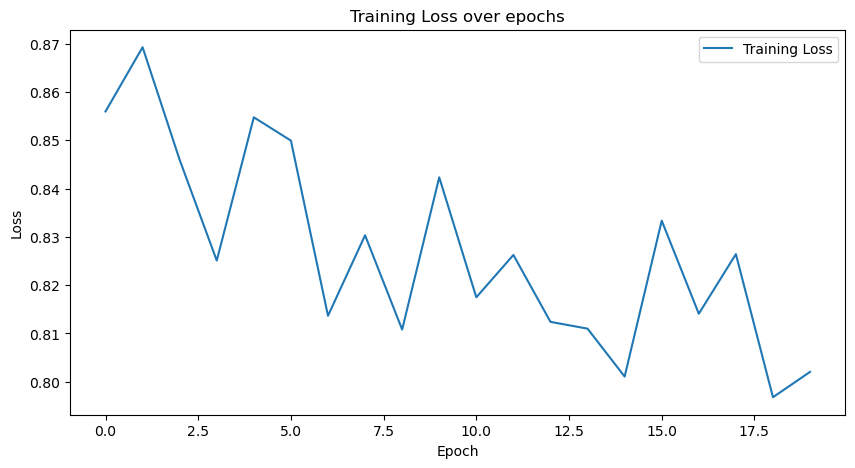

In [28]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_prog, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

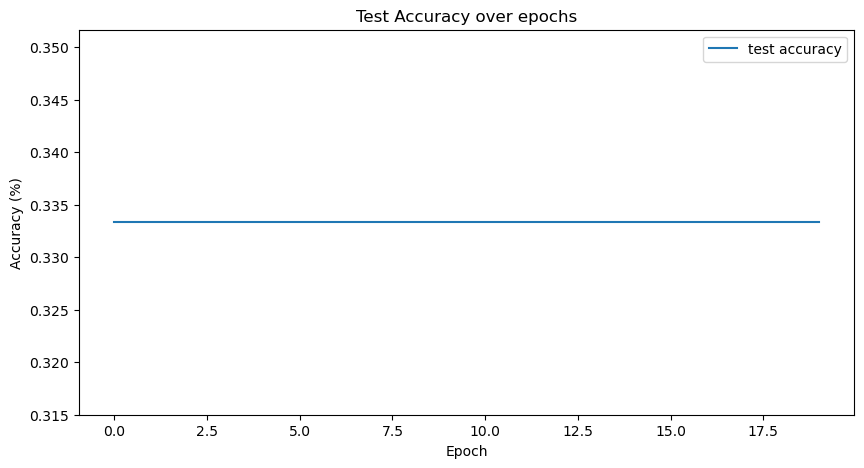

In [29]:
# plot testing accuracy
def plot_accuracy(accuracy_progress_list):
    plt.figure(figsize=(10, 5))
    for label, acc in accuracy_progress_list:
        plt.plot(range(epochs), acc, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over epochs')
    plt.legend()
    plt.show()

plot_accuracy([('test accuracy', acc_prog)])

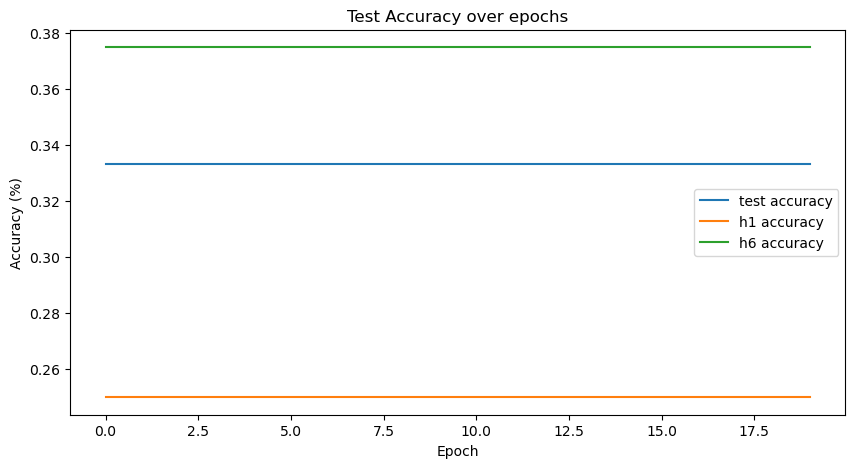

In [30]:
plot_accuracy([('test accuracy', acc_prog), ('h1 accuracy', acc_h1_prog), ('h6 accuracy', acc_h6_prog)])